In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
message = "Great Science!"

In [0]:
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
path_model  = '/content/gdrive/My Drive/Goodreads/models/'
path_data = '/content/gdrive/My Drive/Goodreads/data/'

def load_data(file_name):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            if count % 10000 == 0:
                print(count, end=',\n')
            
            if count == 100000:
               break # just for test
            
            # break if reaches the 100th line
            #if (head is not None) and (count > head):
                #break
    return data

In [6]:
import pandas as pd
import numpy as np
import pickle
from textwrap import wrap
import re
import gzip
import json
import os
import warnings

import matplotlib.pyplot as plt
from skimage import io

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia

from gensim.models.doc2vec import Doc2Vec
from gensim.test.utils import get_tmpfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

warnings.filterwarnings('ignore')

dv = Doc2Vec.load(path_model+"doc2vec_model")
tf = pickle.load(open(path_model+"tfidf_model.pkl", "rb"))
svd = pickle.load(open(path_model+"svd_model.pkl", "rb"))
svd_feature_matrix = pickle.load(open(path_model+"lsa_embeddings.pkl", "rb"))
doctovec_feature_matrix = pickle.load(open(path_model+"doctovec_embeddings.pkl", "rb"))
#reviews = load_data(os.path.join(path_data, 'goodreads_reviews_dedup.json.gz'))

DIR = '/content/gdrive/My Drive/Goodreads/data'
reviews = pd.read_csv(os.path.join(DIR, 'df_reviews1000.csv'))
df = pd.DataFrame(reviews)
hal = sia()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [7]:
message_array = dv.infer_vector(doc_words=message.split(" "), epochs=200)
message_array = message_array.reshape(1, -1)
print(message_array)

[[ 3.3133368e-03  4.2657149e-03  1.3652691e-03 -4.2711711e-03
  -1.4308257e-03  3.4282389e-03 -2.9169973e-03 -2.2740618e-03
  -1.1899951e-03  1.5502078e-03 -1.4811252e-03 -3.4706485e-03
  -1.8314375e-03  4.7318893e-03 -3.4700113e-03 -1.6378142e-03
  -6.9399760e-04 -6.7444856e-04  4.9002464e-03  1.4143809e-03
  -1.2933689e-03 -3.7905225e-03 -4.4401889e-04  1.8981608e-03
  -1.9821587e-03 -2.5053935e-03 -4.9907493e-04  4.3840776e-03
   3.9484887e-03 -2.0718095e-03 -9.3906588e-04  2.9034764e-03
  -2.1274081e-03 -4.9740225e-03 -2.2796129e-03 -3.2430617e-03
   4.4067558e-03 -4.5957072e-03 -1.0206845e-03 -1.9580745e-03
   1.8367709e-03 -1.6375822e-04 -6.8791857e-04 -4.6710437e-03
   4.5387358e-03 -2.4226885e-03  3.0125051e-03  3.2580481e-04
  -2.1684517e-03 -2.0183588e-03 -2.7869800e-03 -3.6201023e-03
   8.0462795e-04 -1.1671126e-03 -3.3862684e-03  6.0940039e-04
  -6.2203687e-04  4.5696213e-03 -2.5882539e-03  1.7871208e-03
   1.0766584e-03 -4.8008435e-03  6.5812128e-05 -2.8980148e-03
   2.585

In [8]:
message.split(" ")

['Great', 'Science!']

In [0]:
def get_message_sentiment(message):
  sentences = re.split('\.|\but',message)
  sentences = [x for x in sentences if x != ""]
  love_message = ""
  hate_message = ""
  for s in sentences:
    sentiment_scores = hal.polarity_scores(s)
    if sentiment_scores['neg'] > 0:
      hate_message = hate_message + s
    else:
      love_message = love_message + s
  return love_message, hate_message
      
      

def get_ensemble_similarity_scores(message):
  message = clean_text(message)
  bow_message_array = get_message_tfidf_embedding_vector(message)
  semantic_message_array = get_message_doctovec_embedding_vector(message)
  
  bow_similarity = get_similarity_scores(bow_message_array, svd_feature_matrix)
  semantic_similarity = get_similarity_scores(semantic_message_array, doctovec_feature_matrix)
  
  ensemble_similarity = pd.merge(semantic_similarity, bow_similarity, left_index=True, right_index=True)
  ensemble_similarity.columns = ["semantic_similarity", "bow_similarity"]
  ensemble_similarity['ensemble_similarity'] = (ensemble_similarity["semantic_similarity"] \
                                                      + ensemble_similarity["bow_similarity"])/2
  ensemble_similarity.sort_values(by="ensemble_similarity", ascending=False, inplace=True)
  return ensemble_similarity


def get_message_tfidf_embedding_vector(message):
  message_array = tf.transform([message]).toarray()
  message_array = svd.transform(message_array)
  message_array = message_array[:,0:100].reshape(1, -1)
  return message_array


def get_message_doctovec_embedding_vector(message):
  message_array = dv.infer_vector(doc_words=message.split(" "), epochs=200)
  message_array = message_array.reshape(1, -1)
  return message_array


def get_similarity_scores(message_array, embeddings):
  cosine_sim_matrix = pd.DataFrame(cosine_similarity(X=embeddings,Y=message_array,dense_output=True))
  cosine_sim_matrix.set_index(embeddings.index, inplace=True)
  cosine_sim_matrix.columns = ["cosine_similarity"]
  return cosine_sim_matrix


def get_dissimilarity_scores(message):
  message = clean_text(message)
  bow_message_array = get_message_tfidf_embedding_vector(message)
  semantic_message_array = get_message_doctovec_embedding_vector(message)
  
  dissimilarity = get_similarity_scores(bow_message_array, svd_feature_matrix)
  dissimilarity.columns = ["dissimilarity"]
  dissimilarity.sort_values(by="dissimilarity", ascending=False, inplace=True)
  return dissimilarity


def query_similar_books(message, n):
  
  love_message, hate_message = get_message_sentiment(message)
  
  similar_books = get_ensemble_similarity_scores(love_message)
  dissimilar_books = get_dissimilarity_scores(hate_message)
  dissimilar_books = dissimilar_books.query('dissimilarity > .3')
  similar_books = similar_books.drop(dissimilar_books.index)
  
  return similar_books.head(n)

In [10]:
query_similar_books(message,10)

,semantic_similarity,bow_similarity,ensemble_similarity
"(29579, Foundation (Foundation #1), 4.13, https://images.gr-assets.com/books/1417900846m/29579.jpg)",0.400059,0.656441,0.528250
"(112537, Rendezvous with Rama (Rama, #1), 4.06, https://images.gr-assets.com/books/1405456427m/112537.jpg)",0.352011,0.676084,0.514047
"(41804, I, Robot (Robot #0.1), 4.17, https://images.gr-assets.com/books/1388321463m/41804.jpg)",0.365746,0.655420,0.510583
"(414999, Childhood's End, 4.09, https://images.gr-assets.com/books/1320552628m/414999.jpg)",0.366437,0.632721,0.499579
"(61666, Contact, 4.11, https://images.gr-assets.com/books/1408792653m/61666.jpg)",0.402221,0.580850,0.491535
"(29580, Second Foundation (Foundation #3), 4.23, https://images.gr-assets.com/books/1417900922m/29580.jpg)",0.358281,0.599671,0.478976
"(7967, Speaker for the Dead (Ender's Saga, #2), 4.04, https://images.gr-assets.com/books/1295660894m/7967.jpg)",0.364533,0.587275,0.475904
"(17214, Starship Troopers, 3.99, https://images.gr-assets.com/books/1406457252m/17214.jpg)",0.291789,0.620651,0.456220
"(51964, Old Man's War (Old Man's War, #1), 4.23, https://images.gr-assets.com/books/1487044882m/51964.jpg)",0.295962,0.601940,0.448951
"(76778, The Martian Chronicles, 4.12, https://images.gr-assets.com/books/1374049948m/76778.jpg)",0.320464,0.565454,0.442959


In [0]:
result = query_similar_books(message,5)

book title: Foundation (Foundation #1)
ratings: 4.13


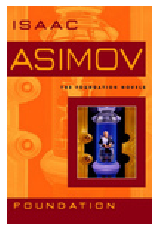

book title: Rendezvous with Rama (Rama, #1)
ratings: 4.06


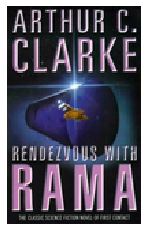

book title: I, Robot (Robot #0.1)
ratings: 4.17


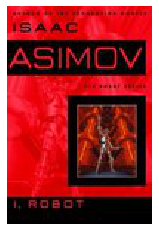

book title: Childhood's End
ratings: 4.09


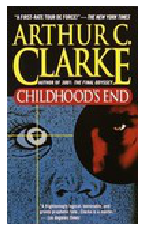

book title: Contact
ratings: 4.11


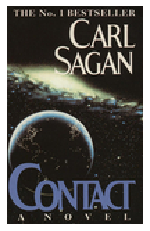

In [16]:
for index in result.index:
  print("book title:", index[1])
  print("ratings:", index[2])
  book_image = index[3]
  image = io.imread(book_image)
  plt.imshow(image)
  plt.axis('off')
  #plt.title(index[1])
  plt.show()
